**Challenge: make a neural network:**

For this challenge you have two options for how to use neural networks . Choose one of the following:

Use RBM to perform feature extraction on an image-based dataset that you find or create. If you go this route, present the features you extract and explain why this is a useful feature extraction method in the context you’re operating in. DO NOT USE either the MNIST digit recognition database or the iris data set. They’ve been worked on in very public ways very very many times and the code is easily available. (However, that code could be a useful resource to refer to). _OR_,

Create a multi-layer perceptron neural network model to predict on a labeled dataset of your choosing. Compare this model to either a boosted tree or a random forest model and describe the relative tradeoffs between complexity and accuracy. Be sure to vary the hyperparameters of your MLP!

Once you've chosen which option you prefer, get to modeling and submit your work below.

**Introduction**

The Sign Language MNIST is presented here and follows the CSV format with labels and pixel values in single rows. The American Sign Language letter database of hand gestures represent a multi-class problem with 24 classes of letters (excluding J and Z which require motion) but we use only 10 first label to better illustration.

The dataset format is patterned to match closely with the classic MNIST. Each training and test case represents a label (0-25) as a one-to-one map for each alphabetic letter A-Z (and no cases for 9=J or 25=Z because of gesture motions). The training data (27,455 cases) and test data (7172 cases) with a header row of label, pixel1,pixel2….pixel784 which represent a single 28x28 pixel image with grayscale values between 0-255. 

In [1]:
# Import some packages and libraries:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import time
import umap
import scipy
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.model_selection import cross_val_score
from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.base import clone

import warnings
warnings.filterwarnings(action="ignore")

In [2]:
# Load dataset:
df = pd.read_csv(r'C:\Users\mebra.DESKTOP-L12LJA6\Thinkful Works\PythonThinkful\sign_mnist_train\sign_mnist_train.csv')

In [3]:
# Look at the dataset:
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [4]:
# Only keep 10 first label:
df = df[df['label']<10]
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
6,8,134,134,135,135,136,137,137,138,138,...,109,102,91,65,138,189,179,181,181,179


In [5]:
# Look at the shape of dataset:
df.shape

(9902, 785)

In [6]:
# Look at the type of dataset:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9902 entries, 0 to 27442
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 59.4 MB


In [7]:
# Findout missing values:

sum_null_columns = df.isnull().sum().sort_values(ascending=False)
percent_null_columns = (df.isnull().sum()*100/df.isnull().count()).sort_values(ascending=False)
percent_null_columns[percent_null_columns>0]

Series([], dtype: float64)

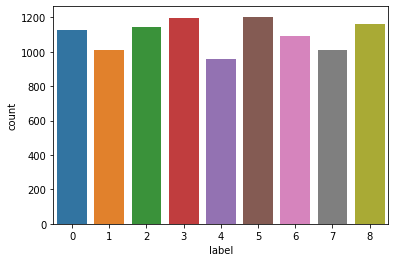

In [8]:
# Look at the number of label:
sns.countplot(df['label'])

In [9]:
# Define Feature and target variable and Scaling images with divided by 255:

X = df.drop('label', axis=1)/ 255
y = df['label']

print(X.shape, y.shape)

(9902, 784) (9902,)


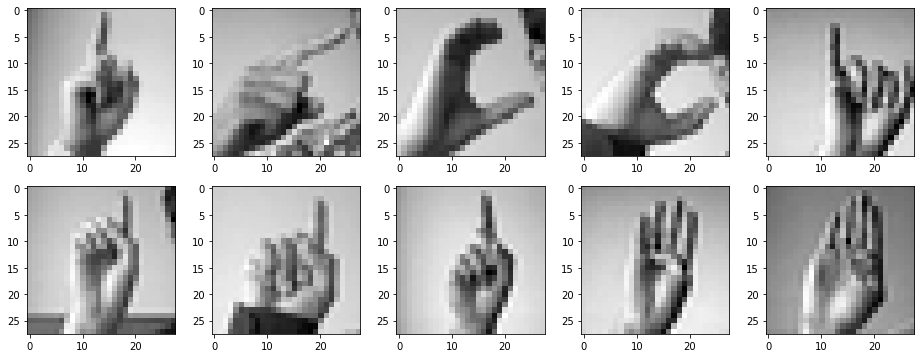

In [10]:
# Plot labels images and see what they look like:

plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X.iloc[i,:].values.reshape([28,28]), cmap='gray');

In [11]:
# Setting up nudge dataset:

def nudge_dataset(X, Y):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 8x8 images in X around by 1px to left, right, down, up
    """
    direction_vectors = [
        [[0, 1, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [1, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 1],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]]]

    def shift(x, w):
        return convolve(x.reshape((28, 28)), mode='constant', weights=w).ravel()

    X = np.concatenate([X] + [np.apply_along_axis(shift, 1, X, vector) for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y


In [12]:

# Load Data
X = np.asarray(X, 'float32')
X, Y = nudge_dataset(X, y)
X = (X - np.min(X, 0)) / (np.max(X, 0) + 0.0001)  # 0-1 scaling

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=0)


In [13]:
# Models we will use
logistic = linear_model.LogisticRegression(solver='newton-cg', tol=1)
rbm = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(steps=[('rbm', rbm), ('logistic', logistic)])


In [14]:
# Training Hyper-parameters:
# These were set by cross-validation, using a GridSearchCV. 
# Here we are not performing cross-validation to  save time.

rbm.learning_rate = 0.06
rbm.n_iter = 10

# More components tend to give better prediction performance, but larger fitting time
rbm.n_components = 100
logistic.C = 60000

# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, Y_train)

# Training the Logistic regression classifier directly on the pixel
raw_pixel_classifier = clone(logistic)##3??????
raw_pixel_classifier.C = 100.
raw_pixel_classifier.fit(X_train, Y_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -471.15, time = 12.51s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -465.07, time = 12.00s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -462.94, time = 11.82s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -458.40, time = 12.86s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -467.42, time = 11.53s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -461.83, time = 9.67s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -458.49, time = 11.02s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -453.88, time = 10.43s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -462.87, time = 10.57s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -463.87, time = 8.38s


LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=1, verbose=0,
                   warm_start=False)

In [15]:
# Evaluation

Y_pred = rbm_features_classifier.predict(X_test)
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

Y_pred = raw_pixel_classifier.predict(X_test)
print("Logistic regression using raw pixel features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))


Logistic regression using RBM features:
              precision    recall  f1-score   support

           0       0.30      0.86      0.45      1122
           1       0.59      0.07      0.13      1042
           2       0.95      0.87      0.91      1150
           3       0.36      0.47      0.40      1157
           4       0.61      0.21      0.31       967
           5       0.46      0.30      0.37      1208
           6       0.59      0.69      0.64      1073
           7       0.78      0.52      0.63      1032
           8       0.37      0.29      0.32      1151

    accuracy                           0.48      9902
   macro avg       0.56      0.48      0.46      9902
weighted avg       0.55      0.48      0.46      9902


Logistic regression using raw pixel features:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1122
           1       1.00      1.00      1.00      1042
           2       1.00      1.00      1.00  

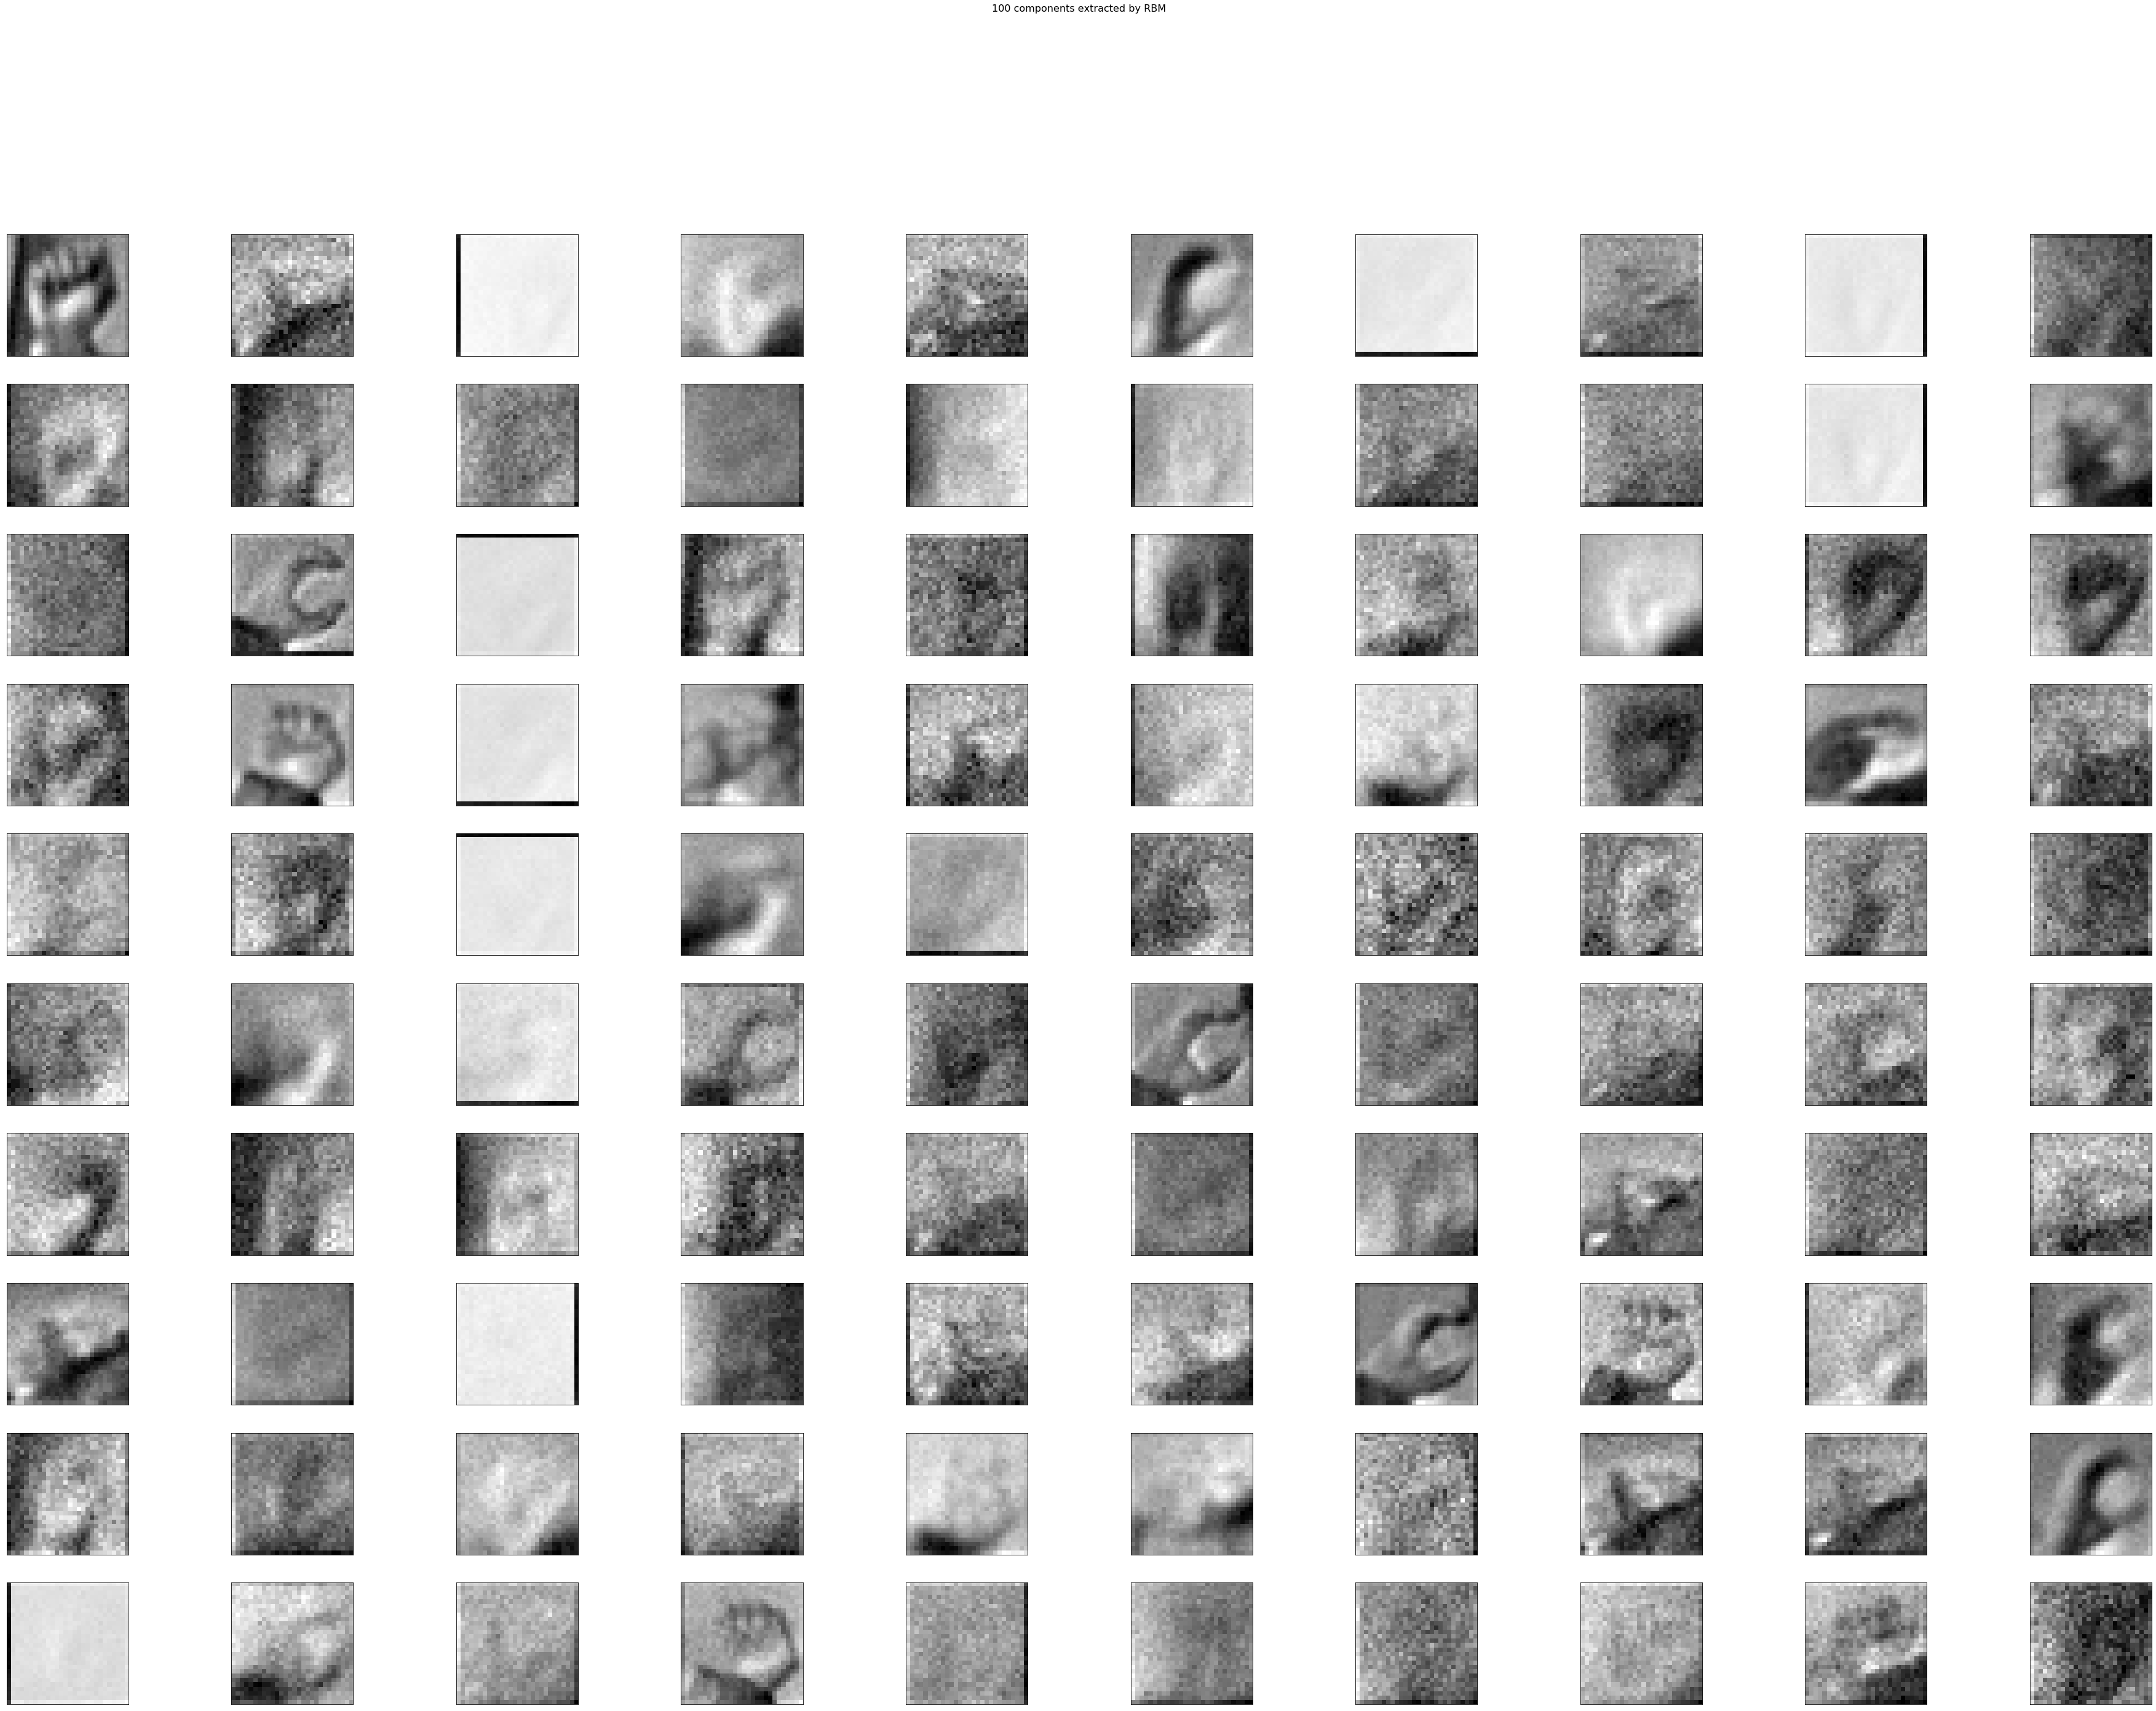

In [23]:
# Plotting

plt.figure(figsize=(60, 40))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((28, 28)), cmap='gray')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('100 components extracted by RBM', fontsize = 16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
plt.show()

 I extracted 10 components from RBM to see more clear.